In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

from sklearn.metrics import ConfusionMatrixDisplay
from utils.elfnn import ELFNN

In [2]:
# instantiate ELFNN object
elf = ELFNN()

### Load and analyze training data

In [3]:
elf.load_data(sort=True, structure=True, additional=True, drop_duplicates=True)

Parse additional: 100%|██████████| 97/97 [00:00<00:00, 20365.80it/s]            


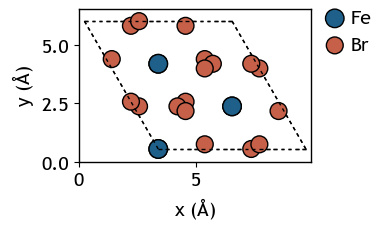

In [4]:
elf.plot_structure(elf.bm.iloc[0].structure);

In [5]:
elf.get_distances(column='elf')    # compute distances from unlabeled examples to most similar labeled example

Compute EMD: 100%|██████████| 186387/186387 [00:12<00:00, 14460.62it/s]         


In [11]:
elf.pca_fit(column='elf_cdf', ev=0.9995)     # perform PCA on the ELF profiles

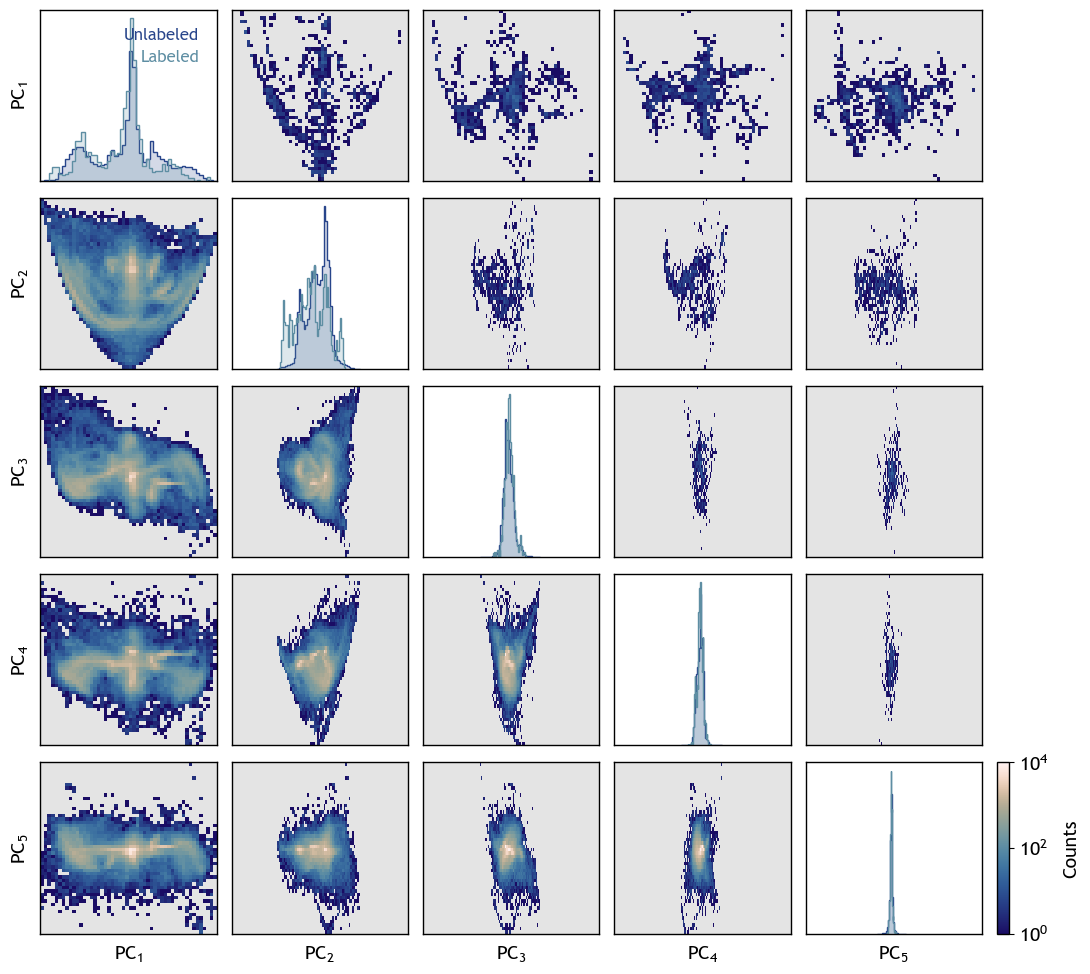

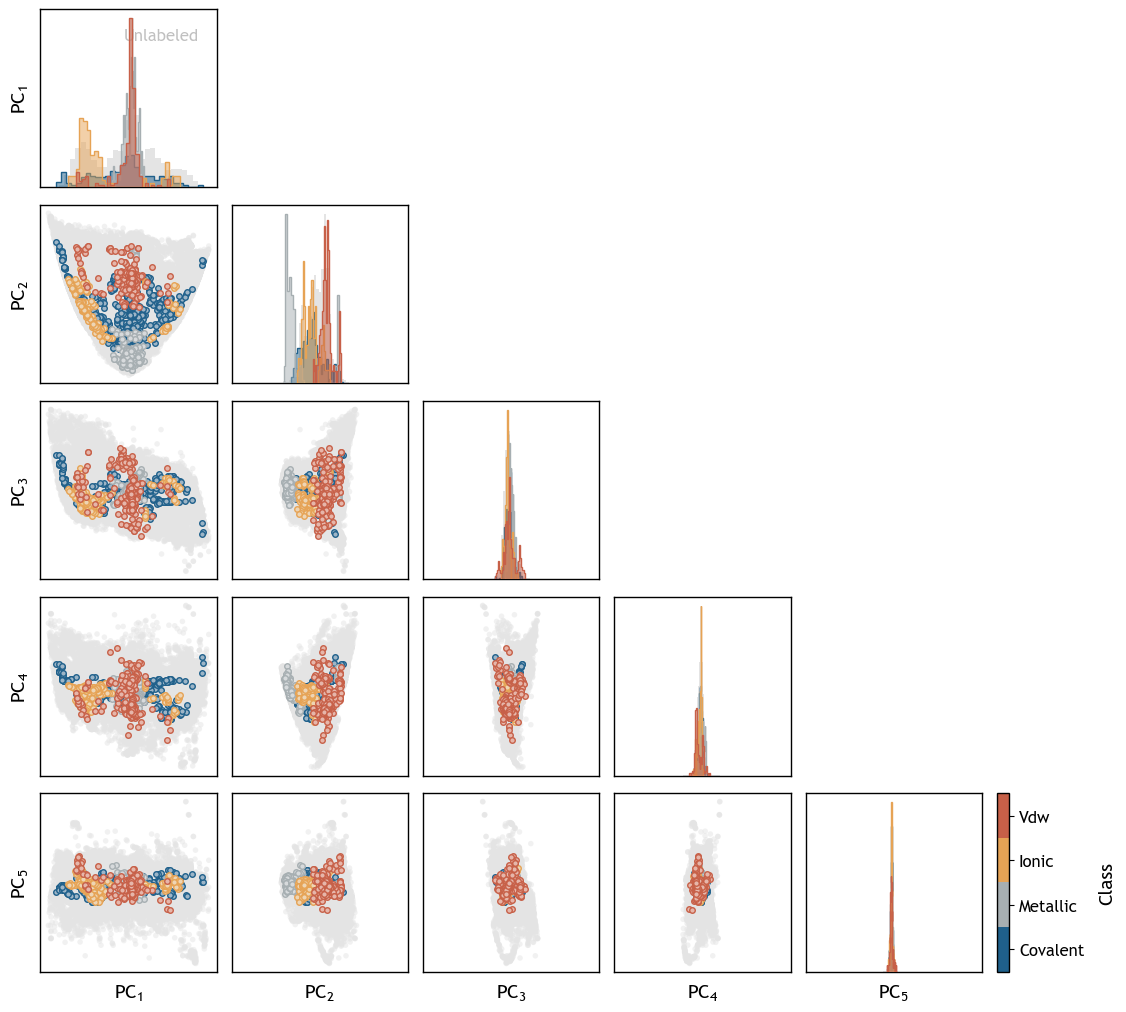

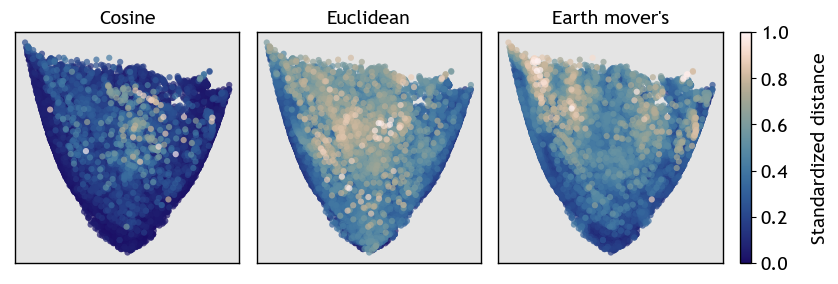

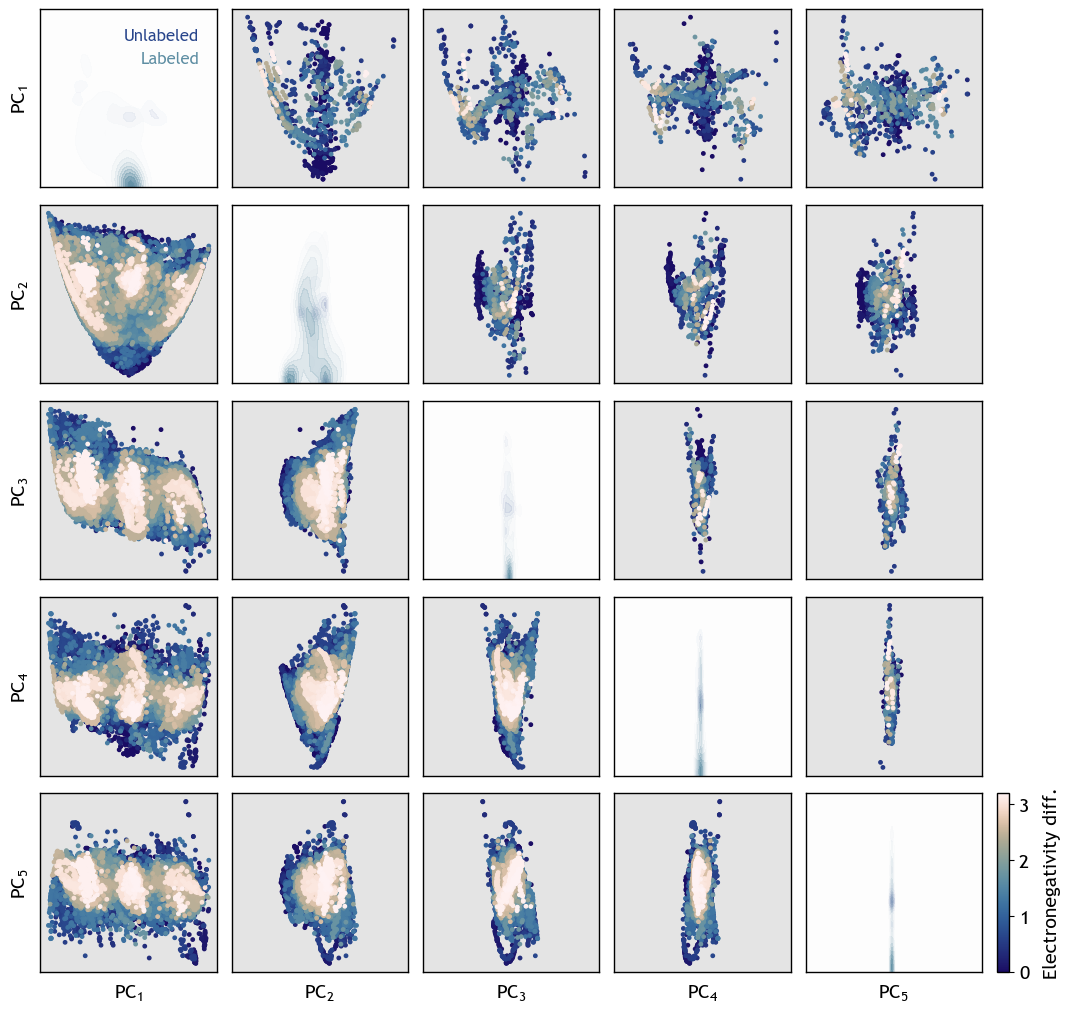

In [8]:
elf.plot_pca_distribution(orig=True)         # visualize distribution of examples in principal component space
elf.plot_pca_labels(orig=True)               # visualize distribution of labels in principal component space
elf.plot_pca_distances(orig=True)            # plot distance to most similar labeled example
elf.plot_pca_features('e_diff', orig=True);  # visualize distribution of features in principal component space

### Process data and train networks

In [12]:
# transform data
elf.pca_fit(ev=0.9995)                         # reduce dimensionality of ELF profiles
elf.prepare_inputs(inputs=['z', 'e_diff'])     # define input columns
elf.scaler_fit()                               # standardize input columns

In [13]:
# compute new label column
elf.bm['_label'] = elf.bond_to_float(elf.bm['label'].tolist())
elf.bm['_label'] = elf.bm['_label'].apply(lambda x: 2 if x >= 2 else x)

In [29]:
# train/test split
test_size = 0.2
elf.stratified_split(test_size, y='_label')    # train/test split

n_splits = 100
elf.kfold_split(n_splits, test_size)           # ensemble split

Class weights: [0.21330411 0.5260629  0.26063299]


In [ ]:
# define and train models
model_path = 'models/stc_040623_srt_pca-cdf_en'
#threshold = 0.4
threshold = np.append(np.arange(0.3,0.9,0.1), 0.999)
elf.init_clf(alpha=0.01, hidden_layer_sizes=(10,),
             activation='relu', max_iter=1000, batch_size=32)                 # define classifier hyperparameters
elf.self_train_clf(threshold=threshold, max_iter=50, model_path=model_path)   # self-train classifier

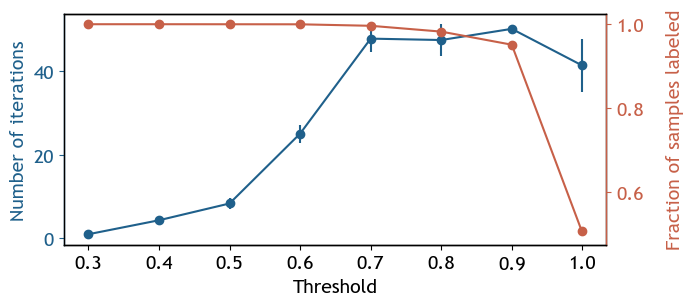

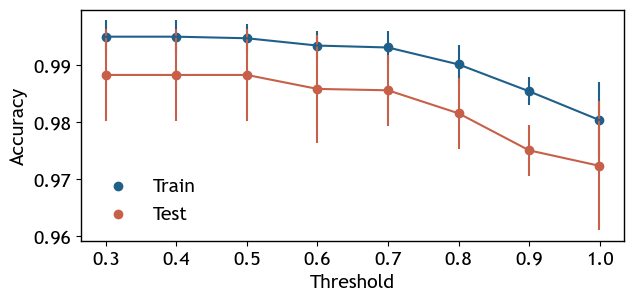

In [62]:
elf.plot_threshold_stats()

In [30]:
# define and train models
model_path = 'models/clf_040623_srt_pca-cdf_en'
elf.init_clf(alpha=0.01, hidden_layer_sizes=(10,),
             activation='relu', max_iter=1000, batch_size=32)    # define classifier hyperparameters
elf.train_clf(model_path=model_path)                             # train classifier

100%|██████████| 100/100 [01:10<00:00,  1.41it/s]                               


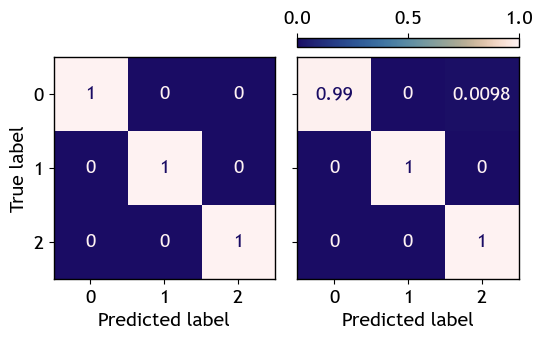

In [31]:
# evaluate trained models
model_path = 'models/clf_040623_srt_pca-cdf_en'
elf.load_model(model_path)
bm = elf.predict(elf.bm, threshold=0.4)

fig, ax = plt.subplots(1,2, figsize=(6,3), sharex=True, sharey=True)
fig.subplots_adjust(wspace=0.1)
cax = fig.add_axes([ax[1].get_position().x0, ax[1].get_position().y1 + 0.02, ax[1].get_position().width, 0.03])

ConfusionMatrixDisplay.from_predictions(bm.iloc[elf.idx_train]['y_class'], bm.iloc[elf.idx_train]['_label'],
                                        cmap=elf.cmap, normalize='true', colorbar=False, ax=ax[0])

g = ConfusionMatrixDisplay.from_predictions(bm.iloc[elf.idx_test]['y_class'], bm.iloc[elf.idx_test]['_label'],
                                            cmap=elf.cmap, normalize='true', colorbar=False, ax=ax[1])

cbar = plt.colorbar(g.im_, cax=cax, orientation='horizontal')
cbar.ax.xaxis.set_ticks_position('top') 

ax[1].set_ylabel('');

In [65]:
for t in threshold:
    bm = elf.predict(elf.bm, threshold=t)
    for i in bm.loc[bm['_label'] != bm['y_class']].formula.tolist():
        print(i, end=', ')
    print('')

Threshold: 0.3
HF_vdw, PbCl2, 
Threshold: 0.4
HF_vdw, PbCl2, 
Threshold: 0.5
HF_vdw, PbCl2, 
Threshold: 0.6000000000000001
HF_vdw, MgS, PbCl2, 
Threshold: 0.7000000000000002
HF_vdw, HgS, MgS, MgS, 
Threshold: 0.8000000000000003
CaO, HgSe, HF_vdw, HgS, MgS, MgS, MgS, MgS, PbCl2, AlCl3, 
Threshold: 0.9000000000000001
CaO, CdSe, CdSe, HgSe, HgSe, HF_vdw, HgS, CdS, MgS, MgS, MgS, MgS, MgS, PbCl2, H2O_vdw, AlCl3, 
Threshold: 0.999
CaO, CdSe, HgSe, HgSe, HF_vdw, ZnTe, HgS, HgS, CdS, CdS, MgO, MgO, MgS, MgS, MgS, MgS, MgS, PbCl2, InI, H2O_vdw, AlCl3, NbOCl3_cov, NbOCl3_cov, 


### Predict on target data using trained networks

In [32]:
# load trained network
model_path = 'models/clf_040623_srt_pca-cdf_en'
elf.load_model(model_path)

In [48]:
# load target examples
data = elf.load_data(dirname='data/labeled/', structure=True, additional=True)

Parse additional: 100%|██████████| 97/97 [00:00<00:00, 18151.49it/s]            


In [41]:
# transform target data
data = elf.pca_transform(data, column='elf_cdf')
data = elf.prepare_inputs(inputs=['z', 'e_diff'], data=data)
data = elf.scaler_transform(data)

In [42]:
# predict on target data
data = elf.predict(data, threshold=0)

/var/folders/09/3ztlds4578xcc3wpml9y2q4m0000gn/T/ipykernel_87492/633451517.py:6: RuntimeWarning: invalid value encountered in true_divide
  ax.plot((bins[1:] + bins[:-1])/2., h_pos/h_tot)


(-0.05, 1.05)

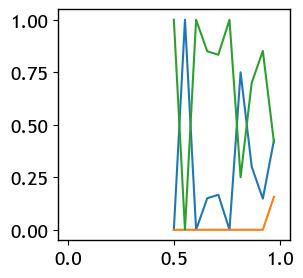

In [40]:
# 2D histogram calibration curve?
fig, ax = plt.subplots(figsize=(3,3))
bins = np.linspace(0,1,20)
for c in range(3):
    h_pos = np.histogram(data.loc[data['_label']==c, 'y_class_mean'], bins=bins)[0]
    h_tot = np.histogram(data['y_class_mean'], bins=bins)[0]
    ax.plot((bins[1:] + bins[:-1])/2., h_pos/h_tot)
ax.set_ylim([-0.05,1.05])
ax.set_xlim([-0.05,1.05])

In [15]:
# regroup data by material
data = elf.regroup(data, by=['id', 'formula', 'structure'], columns=['y_class', 'y_class_mean', 'y_class_std'])